# counts of pcqtl signals

* Fraction of clusters with a signal
* number of credible sets
* number of unique credibles sets
    * grouped by lead varaint
    * grouped by colocalizaion
* broken down by correlation in cluster

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
import scipy as sp
from scipy.stats import linregress, chisquare, ttest_rel, ranksums


import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *


In [2]:
# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

In [3]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

In [4]:
pc_susie = load_across_tissues(config, load_pc_susie)
e_susie = load_across_tissues(config, load_e_susie)

pc_susie_r = load_across_tissues(config, load_pc_susie_r)
e_susie_r = load_across_tissues(config, load_e_susie_r)

clusters = load_across_tissues(config, load_clusters_annotated)

In [5]:
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))
tissue_pal

[(0.7215686274509804, 0.22745098039215686, 0.29411764705882354),
 (0.7667820069204152, 0.3172318339100346, 0.26440599769319495),
 (0.81199538638985, 0.40701268742791236, 0.23469434832756633),
 (0.859361783929258, 0.5010688196847367, 0.20356785851595538),
 (0.9045751633986928, 0.5908496732026144, 0.1738562091503268),
 (0.9497885428681276, 0.6806305267204922, 0.1441445597846982),
 (0.993756247597078, 0.7722106881968474, 0.11650903498654364),
 (0.8962245290272972, 0.758000768935025, 0.23341791618608226),
 (0.7986928104575164, 0.7437908496732026, 0.3503267973856209),
 (0.6965167243367936, 0.7289042675893888, 0.4728027681660899),
 (0.5989850057670127, 0.7146943483275663, 0.5897116493656285),
 (0.5014532871972318, 0.7004844290657439, 0.7066205305651673),
 (0.403921568627451, 0.6862745098039216, 0.8235294117647058)]

In [168]:
def get_cluster_counts(tissue_df, clusters, pc_susie, e_susie, underlying_signals=None, lead_var=True):
    cs_counts_df = pd.DataFrame({'tissue':tissue_df['Tissue'], 
                       'num_clusters':[sum(clusters['tissue_id'] == t) for t in tissue_df['Tissue']],
                       'num_pc_clusters':[pc_susie[pc_susie['tissue_id'] == t]['cluster_id'].nunique() for t in tissue_df['Tissue']],
                        'num_e_clusters':[e_susie[e_susie['tissue_id'] == t]['cluster_id'].nunique() for t in tissue_df['Tissue']],})
    cs_counts_df['percent_e_clusters'] = cs_counts_df['num_e_clusters']/ cs_counts_df['num_clusters'] * 100
    cs_counts_df['percent_pc_clusters'] = cs_counts_df['num_pc_clusters']/ cs_counts_df['num_clusters'] * 100
    cs_counts_df = cs_counts_df.set_index('tissue')

    # e and pcqtl signals in each  by lead var
    combined_susie = pd.concat([e_susie, pc_susie], names=['type', 'idx'], keys=['eQTL', 'pcQTL']).reset_index(drop=0).drop(columns=['idx'])
    credible_sets = combined_susie.groupby(['cs_id', 'tissue_id', 'cluster_id']).agg({'type':'first', 'lead_variant_id':'first'}).reset_index()
    # number of credible sets over tissues
    cs_counts_df['num_eqtl_credible_sets'] = credible_sets[credible_sets['type']=='eQTL'].groupby('tissue_id').agg({'cs_id':'nunique'}) 
    cs_counts_df['num_pcqtl_credible_sets'] = credible_sets[credible_sets['type']=='pcQTL'].groupby('tissue_id').agg({'cs_id':'nunique'}) 

    if lead_var:
        # add lead var overlap information
        lead_var_grouped = credible_sets.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list, 'type':list})
        lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e')
        lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
        lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'Shared', 'eQTL only'), 'pcQTL only')
        credible_sets = lead_var_grouped.explode(['cs_id', 'type'])
        credible_sets['has_pcqtl'] = credible_sets['num_pc_samelead'] > 0
        # num credible sets wtih multiple signals
        cs_counts_df['num_multiple_eqtl_lead_var'] = credible_sets[(credible_sets['type']=='eQTL')&(credible_sets['num_e_samelead']>1)].groupby('tissue_id').agg({'cs_id':'nunique'}) 
        cs_counts_df['num_multiple_pcqtl_lead_var'] = credible_sets[(credible_sets['type']=='pcQTL')&(credible_sets['num_pc_samelead']>1)].groupby('tissue_id').agg({'cs_id':'nunique'}) 
        # unique credible sets by lead var
        deduplicated_lead_vars = credible_sets['type'].reset_index().drop_duplicates()
        cs_counts_df['num_unique_eqtl_lead_var'] = deduplicated_lead_vars[(deduplicated_lead_vars['type']=='eQTL')].groupby('tissue_id').agg({'lead_variant_id':'nunique'}) 
        cs_counts_df['num_unique_pcqtl_lead_var'] = deduplicated_lead_vars[(deduplicated_lead_vars['type']=='pcQTL')].groupby('tissue_id').agg({'lead_variant_id':'nunique'}) 

    if underlying_signals is not None:
        cs_counts_df['num_multiple_eqtl_coloc'] = underlying_signals[underlying_signals['num_e_coloc']>1].groupby('tissue_id').agg({'signal_id':'nunique'}) 
        cs_counts_df['num_multiple_pcqtl_coloc'] = underlying_signals[underlying_signals['num_pc_coloc']>1].groupby('tissue_id').agg({'signal_id':'nunique'}) 
        cs_counts_df['num_unique_eqtl_coloc'] = underlying_signals[underlying_signals['num_e_coloc']>0].groupby('tissue_id').agg({'signal_id':'nunique'}) 
        cs_counts_df['num_unique_pcqtl_coloc'] = underlying_signals[underlying_signals['num_pc_coloc']>0].groupby('tissue_id').agg({'signal_id':'nunique'}) 
        cs_counts_df['num_only_eqtl_coloc'] = underlying_signals[underlying_signals['num_pc_coloc']==0].groupby('tissue_id').agg({'signal_id':'nunique'}) 
        cs_counts_df['num_only_pcqtl_coloc'] = underlying_signals[underlying_signals['num_e_coloc']==0].groupby('tissue_id').agg({'signal_id':'nunique'}) 

    return cs_counts_df

In [7]:
underlying_signals = load_across_tissues(config, load_signal_groups)

In [169]:
cs_counts_df = get_cluster_counts(tissue_df, clusters, pc_susie_r, e_susie_r, underlying_signals=underlying_signals)
# fraction in each
print('e:{}'.format(cs_counts_df['num_e_clusters'].sum()/cs_counts_df['num_clusters'].sum()))
print('pc:{}'.format(cs_counts_df['num_pc_clusters'].sum()/cs_counts_df['num_clusters'].sum()))
print(ttest_rel(cs_counts_df['num_eqtl_credible_sets'], cs_counts_df['num_pcqtl_credible_sets']))

e:0.6803360505739477
pc:0.6656130427549493
TtestResult(statistic=9.429816551976113, pvalue=6.727966809434659e-07, df=12)


In [18]:
cs_counts_old_df = get_cluster_counts(tissue_df, clusters, pc_susie, e_susie)
# fraction in each
print('e:{}'.format(cs_counts_old_df['num_e_clusters'].sum()/cs_counts_old_df['num_clusters'].sum()))
print('pc:{}'.format(cs_counts_old_df['num_pc_clusters'].sum()/cs_counts_old_df['num_clusters'].sum()))
print(ttest_rel(cs_counts_old_df['num_eqtl_credible_sets'], cs_counts_old_df['num_pcqtl_credible_sets']))

e:0.716353352187656
pc:0.7024621527200133
TtestResult(statistic=5.820009806661017, pvalue=8.21274353478906e-05, df=12)


### Number clusters with signal

/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/137747467.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


TtestResult(statistic=5.445939020449321, pvalue=0.00014863377997792712, df=12)

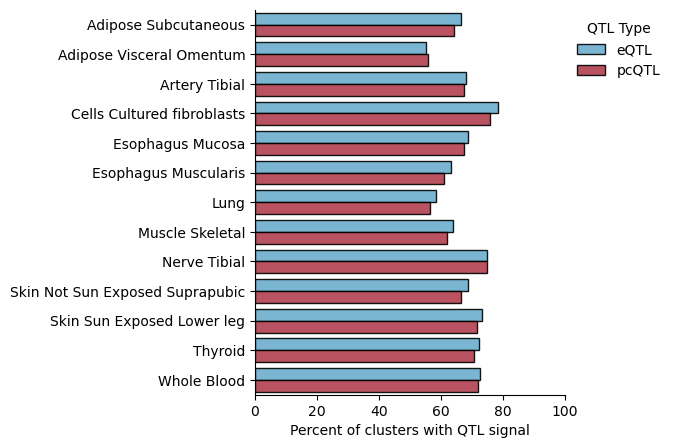

In [19]:
melted = cs_counts_df.melt(id_vars='tissue', value_vars=['percent_e_clusters', 'percent_pc_clusters'], var_name='type', value_name='percent')
fig, ax = plt.subplots(figsize=(4,5))

sns.barplot(melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type', y='tissue', x='percent', palette={'percent_e_clusters':'#67AFD2', 'percent_pc_clusters':'#B83A4B'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['eQTL', 'pcQTL']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

ax.set_ylabel('')
ax.set_xlabel('Percent of clusters with QTL signal')
ax.set_xlim(0,100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ttest_rel(cs_counts_df['num_e_clusters'], cs_counts_df['num_pc_clusters'])

/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/4254894928.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


TtestResult(statistic=5.445939020449321, pvalue=0.00014863377997792712, df=12)

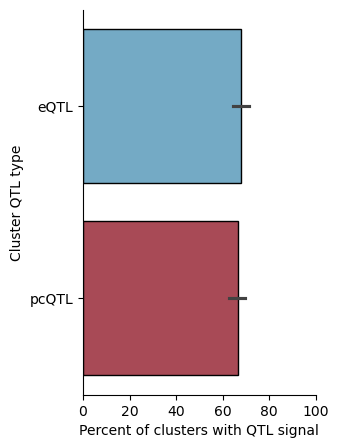

In [20]:
fig, ax = plt.subplots(figsize=(3,5))
sns.barplot(melted, ax = ax, hue='type', y='type', x='percent', edgecolor='k', palette={'percent_e_clusters':'#67AFD2', 'percent_pc_clusters':'#B83A4B'})

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])


ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Percent of clusters with QTL signal')
ax.set_xlim(0,100)
ttest_rel(cs_counts_df['num_e_clusters'], cs_counts_df['num_pc_clusters'])

### number credible sets (total)

/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/1132710371.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


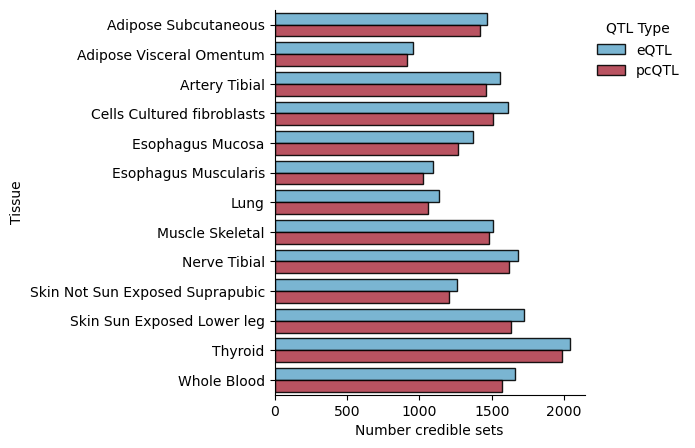

In [21]:
cs_melted = cs_counts_df.melt(id_vars='tissue', value_vars=['num_eqtl_credible_sets', 'num_pcqtl_credible_sets'], var_name='type', value_name='percent')
fig, ax = plt.subplots(figsize=(4,5))
sns.barplot(cs_melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type', y='tissue', x='percent', palette={'num_eqtl_credible_sets':'#67AFD2', 'num_pcqtl_credible_sets':'#B83A4B'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number credible sets')
ax.set_ylabel('Tissue')

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')
# Change legend labels
leg_texts = ['eQTL', 'pcQTL']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
plt.gca().get_legend().set_frame_on(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


plt.show()


/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/1827559213.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


TtestResult(statistic=5.445939020449321, pvalue=0.00014863377997792712, df=12)

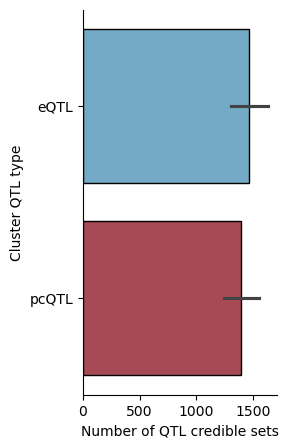

In [22]:
fig, ax = plt.subplots(figsize=(2.5,5))
sns.barplot(cs_melted, ax = ax, hue='type', y='type', x='percent', edgecolor='k', palette={'num_eqtl_credible_sets':'#67AFD2', 'num_pcqtl_credible_sets':'#B83A4B'})


# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])


ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Number of QTL credible sets')
ttest_rel(cs_counts_df['num_e_clusters'], cs_counts_df['num_pc_clusters'])

### number credible sets with shared lead var

In [23]:
# # e and pcqtl signals in each  by lead var
# combined_susie = pd.concat([e_susie, pc_susie], names=['type', 'idx'], keys=['eQTL', 'pcQTL']).reset_index(drop=0).drop(columns=['idx'])
# credible_sets = combined_susie.groupby(['cs_id', 'tissue_id', 'cluster_id']).agg({'type':'first', 'lead_variant_id':'first'}).reset_index()
# # add lead var overlap information
# lead_var_grouped = credible_sets.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list, 'type':list})
# lead_var_grouped['num_eqtl_samelead'] = lead_var_grouped['type'].astype(str).str.count('eQTL')
# lead_var_grouped['num_pcqtl_samelead'] = lead_var_grouped['type'].astype(str).str.count('pcQTL')
# lead_var_grouped['multiple_e'] = lead_var_grouped['num_eqtl_samelead'] > 1
# lead_var_grouped['multiple_pc'] = lead_var_grouped['num_pcqtl_samelead'] > 1
# lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e')
# lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
# lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'Shared', 'eQTL only'), 'pcQTL only')
# credible_sets = lead_var_grouped.explode(['cs_id', 'type'])
# credible_sets['has_pcqtl'] = credible_sets['num_pc_samelead'] > 0

/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/1730191809.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


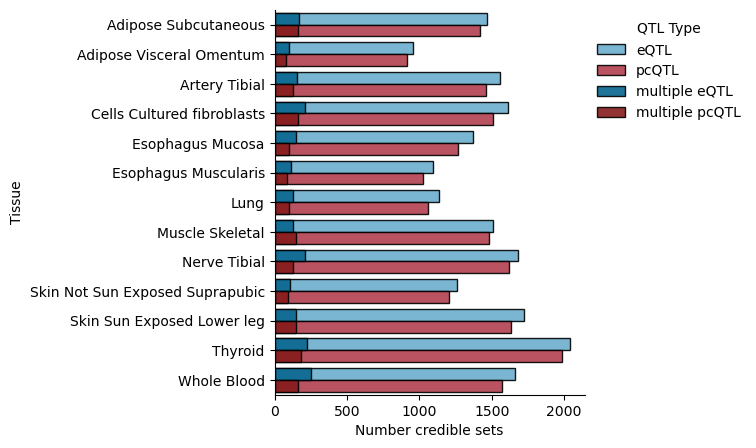

In [25]:
# the full amount
fig, ax = plt.subplots(figsize=(4,5))
sns.barplot(cs_melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type', y='tissue', x='percent', palette={'num_eqtl_credible_sets':'#67AFD2', 'num_pcqtl_credible_sets':'#B83A4B'}, order=tissue_ids)
# the multiple ones colored
multiple_melted = cs_counts_df.melt(id_vars='tissue', value_vars=['num_multiple_eqtl_lead_var', 'num_multiple_pcqtl_lead_var'], var_name='type', value_name='percent')
sns.barplot(multiple_melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type', y='tissue', x='percent',palette={'num_multiple_eqtl_lead_var':'#016895', 'num_multiple_pcqtl_lead_var':'#8C1515'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number credible sets')
ax.set_ylabel('Tissue')
leg = ax.get_legend()
leg.set_title('QTL Type')
# Change legend labels
leg_texts = ['eQTL', 'pcQTL', 'multiple eQTL', 'multiple pcQTL']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.gca().get_legend().set_frame_on(False)

plt.show()


/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/1039986243.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


Text(0.5, 0, 'Number of QTL credible sets')

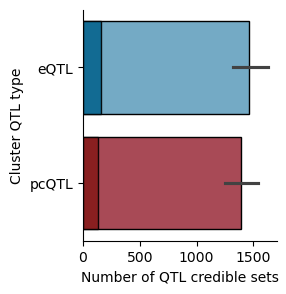

In [26]:
cs_melted['type_short'] = cs_melted['type'].str.split('_').str[1]
multiple_melted['type_short'] = multiple_melted['type'].str.split('_').str[2]

fig, ax = plt.subplots(figsize=(2.5,3))
sns.barplot(cs_melted, ax = ax, hue='type_short', y='type_short', x='percent', edgecolor='k', palette={'eqtl':'#67AFD2', 'pcqtl':'#B83A4B'})
sns.barplot(multiple_melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type_short', y='type_short', x='percent',palette={'eqtl':'#016895', 'pcqtl':'#8C1515'}, errorbar=None)


# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])


ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Number of QTL credible sets')

### number unique credible sets (lead var)

/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/1342230618.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


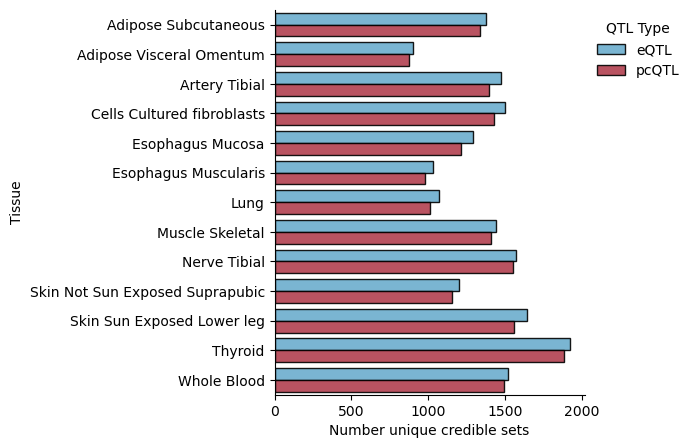

In [36]:
# combined for unique signals
lead_var_melted = cs_counts_df.melt(id_vars='tissue', value_vars=['num_unique_eqtl_lead_var', 'num_unique_pcqtl_lead_var'], var_name='type', value_name='percent')
fig, ax = plt.subplots(figsize=(4,5))
sns.barplot(lead_var_melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type', y='tissue', x='percent', palette={'num_unique_eqtl_lead_var':'#67AFD2', 'num_unique_pcqtl_lead_var':'#B83A4B'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number unique credible sets')
ax.set_ylabel('Tissue')
leg = ax.get_legend()
leg.set_title('QTL Type')
# Change legend labels
leg_texts = ['eQTL', 'pcQTL']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
plt.gca().get_legend().set_frame_on(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


plt.show()


/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/1728563261.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


TtestResult(statistic=7.65023522068821, pvalue=5.9241750106040765e-06, df=12)

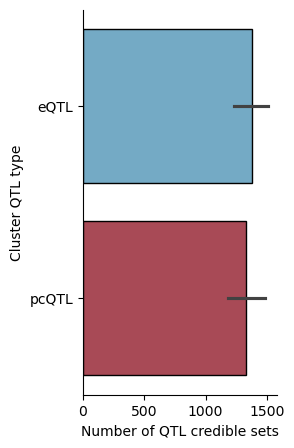

In [37]:
fig, ax = plt.subplots(figsize=(2.5,5))
sns.barplot(lead_var_melted, ax = ax, hue='type', y='type', x='percent', edgecolor='k', palette={'num_unique_eqtl_lead_var':'#67AFD2', 'num_unique_pcqtl_lead_var':'#B83A4B'})


# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])


ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Number of QTL credible sets')
ttest_rel(cs_counts_df['num_unique_eqtl_lead_var'], cs_counts_df['num_unique_pcqtl_lead_var'])

#### number unique credible sets coloc

/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/203687826.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


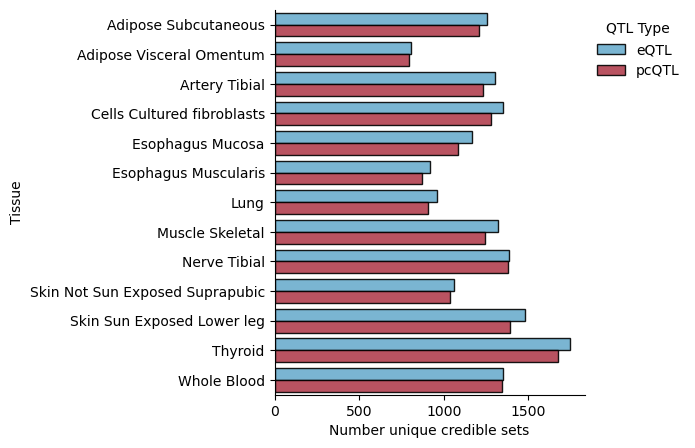

In [38]:
# combined for unique signals
coloc_melted = cs_counts_df.melt(id_vars='tissue', value_vars=['num_unique_eqtl_coloc', 'num_unique_pcqtl_coloc'], var_name='type', value_name='percent')
fig, ax = plt.subplots(figsize=(4,5))
sns.barplot(coloc_melted,ax=ax,alpha=.9, saturation=.9, edgecolor='k', width=.8, hue='type', y='tissue', x='percent', palette={'num_unique_eqtl_coloc':'#67AFD2', 'num_unique_pcqtl_coloc':'#B83A4B'}, order=tissue_ids)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number unique credible sets')
ax.set_ylabel('Tissue')
leg = ax.get_legend()
leg.set_title('QTL Type')
# Change legend labels
leg_texts = ['eQTL', 'pcQTL']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
plt.gca().get_legend().set_frame_on(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


plt.show()


/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/2802314718.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['eQTL', 'pcQTL'])


TtestResult(statistic=5.9752552910609396, pvalue=6.457597319535477e-05, df=12)

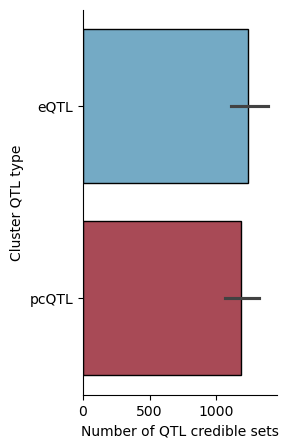

In [39]:
fig, ax = plt.subplots(figsize=(2.5,5))
sns.barplot(coloc_melted, ax = ax, hue='type', y='type', x='percent', edgecolor='k', palette={'num_unique_eqtl_coloc':'#67AFD2', 'num_unique_pcqtl_coloc':'#B83A4B'})


# make the plot pretty
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticklabels(['eQTL', 'pcQTL'])

ax.set_ylabel('Cluster QTL type')
ax.set_xlabel('Number of QTL credible sets')
ttest_rel(cs_counts_df['num_unique_eqtl_coloc'], cs_counts_df['num_unique_pcqtl_coloc'])

## split by cluster correlation

In [252]:
clusters

,N_genes,Transcripts,Perc_cor,Mean_cor,Mean_pos_cor,Mean_neg_cor,Chromosome,Tissue,cluster_size,cluster_tss_size,...,num_ctcf_point,has_ctcf_point,has_neg_corr,has_high_pos_corr,cluster_id,abs_cor,max_pos_neg_cor,tissue_id,corr_decile,corr_bin
0,9,"ENSG00000203786.6,ENSG00000197084.5,ENSG000001...",0.722222,0.351570,0.373850,-0.027194,1,Adipose_Subcutaneous,346623,346623,...,0.0,False,True,False,ENSG00000163207.6_ENSG00000163209.14_ENSG00000...,0.373850,0.373850,Adipose_Subcutaneous,3,3
1,5,"ENSG00000168765.16,ENSG00000213366.12,ENSG0000...",1.000000,0.475357,0.475357,NaN,1,Adipose_Subcutaneous,119347,84957,...,0.0,False,False,False,ENSG00000134184.12_ENSG00000134201.10_ENSG0000...,0.475357,0.475357,Adipose_Subcutaneous,5,4
2,4,"ENSG00000121310.16,ENSG00000116171.17,ENSG0000...",0.833333,0.293622,0.293622,NaN,1,Adipose_Subcutaneous,246722,215420,...,0.0,False,False,False,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,0.293622,0.293622,Adipose_Subcutaneous,2,2
3,4,"ENSG00000117228.9,ENSG00000162645.12,ENSG00000...",0.833333,0.295550,0.295550,NaN,1,Adipose_Subcutaneous,146613,133572,...,0.0,False,False,False,ENSG00000117228.9_ENSG00000162645.12_ENSG00000...,0.295550,0.295550,Adipose_Subcutaneous,2,2
4,4,"ENSG00000162687.16,ENSG00000000971.15,ENSG0000...",1.000000,0.346542,0.346542,NaN,1,Adipose_Subcutaneous,606410,210532,...,0.0,False,False,False,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,0.346542,0.346542,Adipose_Subcutaneous,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12017,2,"ENSG00000128271.21,ENSG00000100024.14",1.000000,0.260535,0.260535,NaN,22,Whole_Blood,110511,76228,...,5.0,True,False,False,ENSG00000100024.14_ENSG00000128271.21,0.260535,0.260535,Whole_Blood,1,2
12018,2,"ENSG00000099991.17,ENSG00000099994.10",1.000000,0.218315,0.218315,NaN,22,Whole_Blood,177918,170067,...,10.0,True,False,False,ENSG00000099991.17_ENSG00000099994.10,0.218315,0.218315,Whole_Blood,0,2
12019,2,"ENSG00000183773.15,ENSG00000099949.18",1.000000,0.221136,0.221136,NaN,22,Whole_Blood,33930,14354,...,0.0,False,False,False,ENSG00000099949.18_ENSG00000183773.15,0.221136,0.221136,Whole_Blood,0,2
12020,2,"ENSG00000100075.9,ENSG00000070371.15",1.000000,0.216789,0.216789,NaN,22,Whole_Blood,116141,112886,...,2.0,True,False,False,ENSG00000070371.15_ENSG00000100075.9,0.216789,0.216789,Whole_Blood,0,2


In [255]:
clusters['corr_bin'] = np.where(clusters['has_neg_corr'], 0, (clusters['Mean_pos_cor']*10).fillna(0).astype(int)).clip(0, 7)

In [256]:
num_cuts = 10
#clusters['corr_bin'] = pd.qcut(clusters['Mean_cor'], num_cuts, labels=False) 
underlying_signals['cluster_id'] = underlying_signals['signal_id'].str.split('_pc').str[0].str.split('_e').str[0]
cluster_counts_corr_split = []

for i in clusters['corr_bin'].unique():
    sub_clusters = clusters[clusters['corr_bin'] == i]
    sub_pc_susie = pc_susie_r.merge(sub_clusters, on=['cluster_id', 'tissue_id'], how='inner')
    sub_e_susie = e_susie_r.merge(sub_clusters, on=['cluster_id', 'tissue_id'], how='inner')
    sub_signals = underlying_signals.merge(sub_clusters, on=['cluster_id', 'tissue_id'], how='inner')
    sub_counts = get_cluster_counts(tissue_df, sub_clusters, sub_pc_susie, sub_e_susie, underlying_signals=sub_signals, lead_var=False)
    print(ttest_rel(sub_counts['num_unique_eqtl_coloc'], sub_counts['num_unique_pcqtl_coloc']))
    print(ttest_rel(sub_counts['percent_e_clusters'], sub_counts['percent_pc_clusters']))
    cluster_counts_corr_split.append(sub_counts)

TtestResult(statistic=-1.0017734138479208, pvalue=0.33622610724507895, df=12)
TtestResult(statistic=1.3849866488748197, pvalue=0.19126449247717528, df=12)
TtestResult(statistic=0.6297016160964091, pvalue=0.5406941842890245, df=12)
TtestResult(statistic=-0.823961868009123, pvalue=0.4260350897064732, df=12)
TtestResult(statistic=7.6321500250949255, pvalue=6.067453973531941e-06, df=12)
TtestResult(statistic=7.138080223300298, pvalue=1.1835826248185314e-05, df=12)
TtestResult(statistic=4.592414375371412, pvalue=0.0006189950558788175, df=12)
TtestResult(statistic=3.5756707773836656, pvalue=0.0038124660416496876, df=12)
TtestResult(statistic=-3.194949339746604, pvalue=0.007704418423959595, df=12)
TtestResult(statistic=-0.7751750161419123, pvalue=0.4532414872843745, df=12)
TtestResult(statistic=-3.6543333018166937, pvalue=0.0033002660328753713, df=12)
TtestResult(statistic=-4.870336791345692, pvalue=0.00038475885833846033, df=12)
TtestResult(statistic=-1.3389110974330105, pvalue=0.20541150008

In [257]:
cluster_counts_corr_split = pd.concat(cluster_counts_corr_split, keys=clusters['corr_bin'].unique(), names=['correlation_bin'])
cluster_counts_corr_split

num_clusters  \
correlation_bin tissue                                          
0               Adipose_Subcutaneous                       37   
                Adipose_Visceral_Omentum                   28   
                Artery_Tibial                              56   
                Cells_Cultured_fibroblasts                 64   
                Esophagus_Mucosa                           35   
...                                                       ...   
6               Nerve_Tibial                               34   
                Skin_Not_Sun_Exposed_Suprapubic            28   
                Skin_Sun_Exposed_Lower_leg                 21   
                Thyroid                                    38   
                Whole_Blood                                28   

                                                 num_pc_clusters  \
correlation_bin tissue                                             
0               Adipose_Subcutaneous                          35   
                Adipose_Visceral_Omentum                      28   
                Artery_Tibial                                 54   
                Cells_Cultured_fibroblasts                    59   
                Esophagus_Mucosa                              35   
...                                                          ...   
6               Nerve_Tibial                                  21   
                Skin_Not_Sun_Exposed_Suprapubic               14   
                Skin_Sun_Exposed_Lower_leg                    12   
                Thyroid                                       26   
                Whole_Blood                                   22   

                                                 num_e_clusters  \
correlation_bin tissue                                            
0               Adipose_Subcutaneous                         35   
                Adipose_Visceral_Omentum                     28   
                Artery_Tibial                                53   
                Cells_Cultured_fibroblasts                   61   
                Esophagus_Mucosa                             35   
...                                                         ...   
6               Nerve_Tibial                                 21   
                Skin_Not_Sun_Exposed_Suprapubic              14   
                Skin_Sun_Exposed_Lower_leg                   11   
                Thyroid                                      26   
                Whole_Blood                                  21   

                                                 percent_e_clusters  \
correlation_bin tissue                                                
0               Adipose_Subcutaneous                      94.594595   
                Adipose_Visceral_Omentum                 100.000000   
                Artery_Tibial                             94.642857   
                Cells_Cultured_fibroblasts                95.312500   
                Esophagus_Mucosa                         100.000000   
...                                                             ...   
6               Nerve_Tibial                              61.764706   
                Skin_Not_Sun_Exposed_Suprapubic           50.000000   
                Skin_Sun_Exposed_Lower_leg                52.380952   
                Thyroid                                   68.421053   
                Whole_Blood                               75.000000   

                                                 percent_pc_clusters  \
correlation_bin tissue                                                 
0               Adipose_Subcutaneous                       94.594595   
                Adipose_Visceral_Omentum                  100.000000   
                Artery_Tibial                              96.428571   
                Cells_Cultured_fibroblasts                 92.187500   
                Esophagus_Mucosa                          100.000000   
...               

/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/2098223616.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(cluster_counts_corr_split, x='correlation_bin', y='num_only_pcqtl_coloc', palette=tissue_pal,)
/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/2098223616.py:1: UserWarning: The palette list has more values (13) than needed (7), which may not be intended.
  ax = sns.barplot(cluster_counts_corr_split, x='correlation_bin', y='num_only_pcqtl_coloc', palette=tissue_pal,)


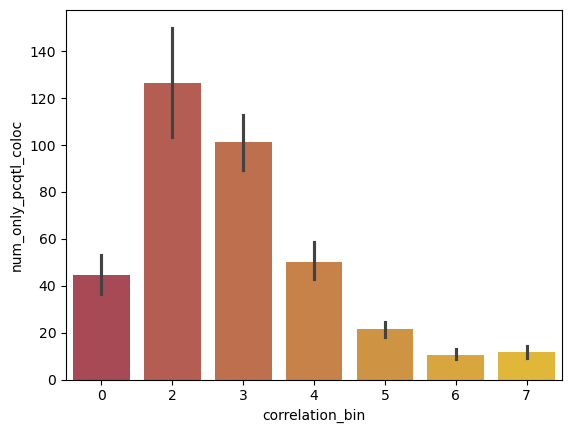

In [258]:
ax = sns.barplot(cluster_counts_corr_split, x='correlation_bin', y='num_only_pcqtl_coloc', palette=tissue_pal,)

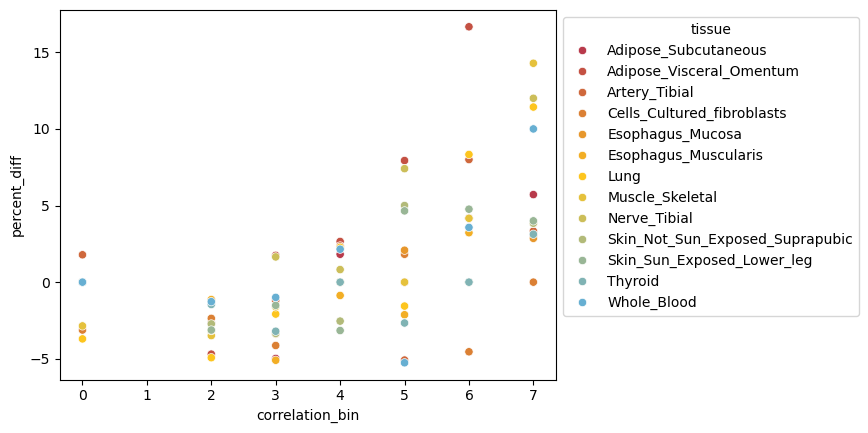

In [259]:
cluster_counts_corr_split['percent_diff'] = cluster_counts_corr_split['percent_pc_clusters'] - cluster_counts_corr_split['percent_e_clusters']
ax = sns.scatterplot(cluster_counts_corr_split, x='correlation_bin', y='percent_diff', hue='tissue', palette=tissue_pal)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


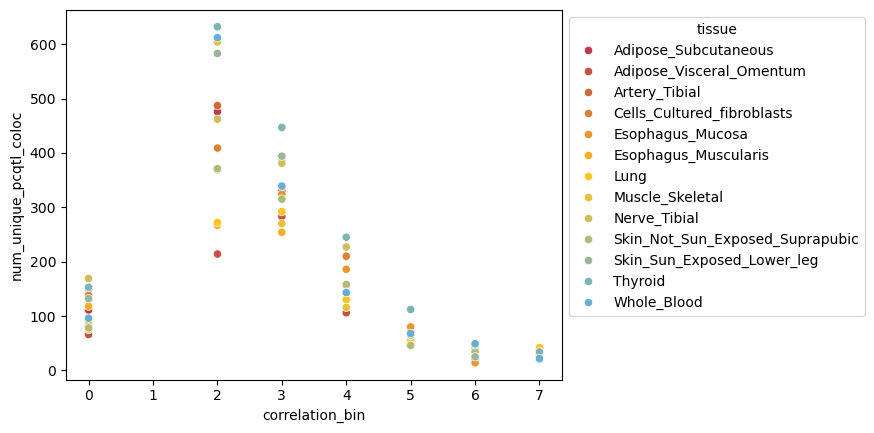

In [260]:
ax = sns.scatterplot(cluster_counts_corr_split, x='correlation_bin', y='num_unique_pcqtl_coloc', hue='tissue', palette=tissue_pal)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/local/scratch/klawren/slrmtmp.46880659/ipykernel_24139/2344528528.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(cluster_counts_corr_split, x='correlation_bin', y='unique_cs_diff', palette=tissue_pal)


ValueError: AxesSubplot(0.125,0.11;0.775x0.77) has no legend attached.

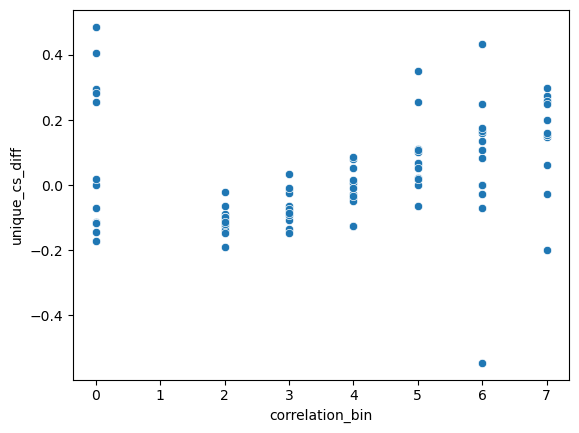

In [265]:
cluster_counts_corr_split['unique_cs_diff'] = (cluster_counts_corr_split['num_unique_pcqtl_coloc'] - cluster_counts_corr_split['num_unique_eqtl_coloc'])/(cluster_counts_corr_split['num_clusters'])
ax = sns.scatterplot(cluster_counts_corr_split, x='correlation_bin', y='unique_cs_diff', palette=tissue_pal)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

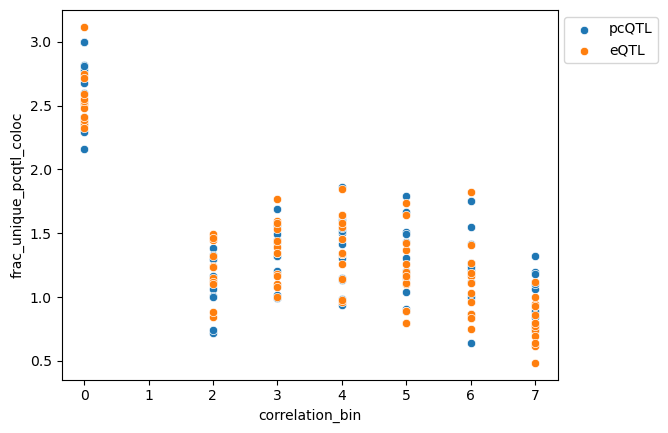

In [267]:
cluster_counts_corr_split['frac_unique_pcqtl_coloc'] = cluster_counts_corr_split['num_unique_pcqtl_coloc']/(cluster_counts_corr_split['num_clusters'])
cluster_counts_corr_split['frac_unique_eqtl_coloc'] = cluster_counts_corr_split['num_unique_eqtl_coloc']/(cluster_counts_corr_split['num_clusters'])

ax = sns.scatterplot(cluster_counts_corr_split, x='correlation_bin', y='frac_unique_pcqtl_coloc', label='pcQTL')
sns.scatterplot(cluster_counts_corr_split, x='correlation_bin', y='frac_unique_eqtl_coloc', label='eQTL', ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<AxesSubplot: xlabel='Mean_cor', ylabel='Count'>

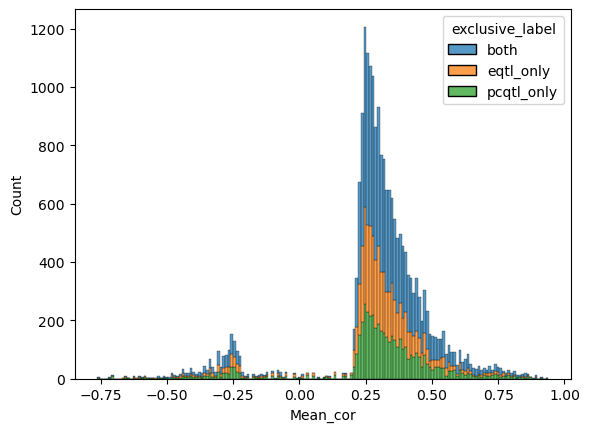

In [262]:
underlying_signals_annot = pd.merge(underlying_signals, clusters[['tissue_id', 'cluster_id', 'Mean_cor']], on=['cluster_id', 'tissue_id'], how='left')
underlying_signals_annot['exclusive_label'] = np.where(underlying_signals_annot['num_e_coloc']>0, 
                                                       np.where(underlying_signals_annot['num_pc_coloc']>0, 'both', 'eqtl_only'), 'pcqtl_only')
sns.histplot(underlying_signals_annot, x='Mean_cor', hue='exclusive_label', multiple='stack')

<AxesSubplot: xlabel='Mean_cor', ylabel='Count'>

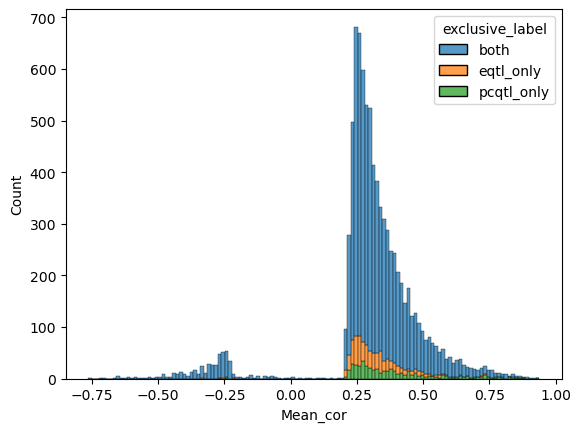

In [229]:
clusters_annot = underlying_signals_annot.groupby(['cluster_id', 'tissue_id']).agg({'num_e_coloc':sum, 'num_pc_coloc':sum, 'Mean_cor':'first'} )
clusters_annot['exclusive_label'] = np.where(clusters_annot['num_e_coloc']>0, 
                                                       np.where(clusters_annot['num_pc_coloc']>0, 'both', 'eqtl_only'), 'pcqtl_only')
sns.histplot(clusters_annot, x='Mean_cor', hue='exclusive_label', multiple='stack')